In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow
!pip install sklearn
!pip install skimage
!pip install colorama

ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [3]:
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import cv2
import keras
import math
import numpy as np
# import h5py
import colorama
from colorama import Fore, Style
from tensorflow.keras import datasets,models
from numpy import ndarray
from keras.models import Model
from keras import Sequential
from keras.layers import Convolution2D
import keras.backend as K
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from skimage.metrics import structural_similarity as ssim


In [4]:
#poredimo tj racunamo slicnost izmedju slike A i slike B
# koristeci metriku MSE
# MSE - srednje kvadratna greska izmedju elemenata originalne slike A i
# i izoblicene slike B 
def mean_squared_error(imageA,imageB):
    res = np.power((imageA.astype('float') - imageB.astype('float')),2.)
    res = np.sum(res)
    w = imageA.shape[0]
    h = imageA.shape[1]
    return res/(w*h)
#koristeci psnr
#PSNR - Peak-signal-to-noise-ratio 
def psnr(y_true,y_pred):
    return -10*K.log(K.mean(K.flatten((y_true-y_pred))**2))/np.log(10)

def psnr1(imageA,imageB):
  mse = np.power(imageA.astype('float') - imageB.astype('float'),2)
  mse = np.mean(mse)
  if mse == 0:
    return 100
  return 20*math.log10(255.0/math.sqrt(mse))


def compare_images(imageA,imageB):
    scores = []
    scores.append(psnr(imageA,imageB))
    scores.append(mean_squared_error(imageA,imageB))
    # ssim  se koristi za poredjenje slicnosti izmedju 2 slike
    # ova mera je napravljena kako bi se unapredile tradicionalne metode za ocenu kvaliteta
    # slike kao sto su gore pomenute psnr i mse 
    # multichannel je ukljucen (True) kako bismo mogli raditi sa slikama koje imaju 3 kanala po pikselu(BGR ili RGB format)
    scores.append(ssim(imageA,imageB,multichannel=True))
    return scores

# arg. f-je je  faktor skaliranja slike
def prepare_image(path,factor):
    # prolazimo kroz direktorijum
    # u nasem slucaju taj direktorijum se nalazi na putanji 
    # drive/MyDrive/slike/Set14
    for file in os.listdir(path):
        # povratna vrednost f-je imread je slika koja je ucitana i nalazi se na
        # prosledjenoj putanji path/file 
        img = cv2.imread(path + '/' + file)
        # nakon ucitavanja ispisujemo dimenzije slike
        # ono sto odavde(ako ukljucimo stampanje) mozemo da vidimo je
        # da prvo ide sirina,pa visina,pa broj kanala,
        # nase slike su u boji tako da imamo 3 kanala
        # print('Image: {},dimension: {}'.format(file,img.shape))
    
        #visina,sirina i broj kanala 
        # originalne slike,a zatim i dimenzije modifikovane(sa faktorom umanjenja 
        # factor) slike
        height,width,_ = img.shape
        new_height = int(height/factor)
        new_width = int(width/factor)
        
        # f-ja resize se koristi za promenu velicine slike (sirina,visina)
        # prvo koristimo bilinearnu interpolaciju(ovo je po default-u te nisam morao postaviti parametar interpolation)
        img1 = cv2.resize(img,(new_width,new_height),interpolation = cv2.INTER_LINEAR)  
        img1 = cv2.resize(img1,(width,height),interpolation = cv2.INTER_LINEAR)
         
        # cuvamo modifikovane slike u direktorijumu slike1(rezultat primene bilinearne interpolacije)
        cv2.imwrite('drive/MyDrive/slike1/{}'.format(file),img1)
        
        # drugo koristimo bikubicnu interpolaciju
        img2 = cv2.resize(img,(new_width,new_height),interpolation = cv2.INTER_CUBIC)  
        img2 = cv2.resize(img2,(width,height),interpolation = cv2.INTER_CUBIC)

        cv2.imwrite('drive/MyDrive/slike2/{}'.format(file),img2)

def load_images(inputdir,inputpath,imagesize):
  imglist = []
  for i in range(len(inputpath)):
    img = cv2.imread(inputdir + inputpath[i],cv2.IMREAD_COLOR)
    img = cv2.resize(img,(128,128))
    imglist.append(img)
  return imglist

def main():
    prepare_image("drive/MyDrive/slike/Set5",3)  
  

if __name__ == "__main__":
    main()

In [5]:
IMAGE_SIZE = 128
CHANNELS = 3
def model():
    model = Sequential()
    model.add(Convolution2D(64,9,activation="relu",input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),padding="same"))
    model.add(Convolution2D(32,3,activation="relu",padding="same"))
    model.add(Convolution2D(3,5,activation="relu",padding="same"))
    return model
SRCNN = model()
SRCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      15616     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 3)       2403      
Total params: 36,483
Trainable params: 36,483
Non-trainable params: 0
_________________________________________________________________


In [6]:
image_path = sorted(os.listdir('drive/MyDrive/slike/General-100/General-100'))
image = load_images('drive/MyDrive/slike/General-100/General-100/',image_path,IMAGE_SIZE)
image /= np.max(image)
image.shape

(100, 128, 128, 3)

In [7]:
label = np.zeros((100,128,128,3),np.float32)
for i in range(image.shape[0]):
  temp = cv2.resize(image[i,:,:,:],(64,64))
  temp = cv2.resize(temp,(128,128))
  label[i,:,:,:]=temp
label.shape

(100, 128, 128, 3)

In [8]:
initial_lerningrate = 2e-3

def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))


SRCNN.compile(loss="mean_squared_error",optimizer=Adam(initial_lerningrate),metrics=[psnr,ssim_loss])
SRCNN.fit(label,image,epochs=200,batch_size=32,verbose=1)

Epoch 1/200
4/4 [==============================] - 32s 68ms/step - loss: 0.3104 - psnr: 6.1725 - ssim_loss: 0.2010
Epoch 2/200
4/4 [==============================] - 0s 34ms/step - loss: 0.0615 - psnr: 12.1184 - ssim_loss: 0.5015
Epoch 3/200
4/4 [==============================] - 0s 33ms/step - loss: 0.0407 - psnr: 14.1130 - ssim_loss: 0.5341
Epoch 4/200
4/4 [==============================] - 0s 30ms/step - loss: 0.0330 - psnr: 14.8318 - ssim_loss: 0.5362
Epoch 5/200
4/4 [==============================] - 0s 30ms/step - loss: 0.0264 - psnr: 15.7931 - ssim_loss: 0.5655
Epoch 6/200
4/4 [==============================] - 0s 32ms/step - loss: 0.0257 - psnr: 15.9495 - ssim_loss: 0.5900
Epoch 7/200
4/4 [==============================] - 0s 32ms/step - loss: 0.0224 - psnr: 16.6132 - ssim_loss: 0.6024
Epoch 8/200
4/4 [==============================] - 0s 32ms/step - loss: 0.0222 - psnr: 16.7088 - ssim_loss: 0.6403
Epoch 9/200
4/4 [==============================] - 0s 31ms/step - loss: 0.0186 -

In [13]:
testImage_path = sorted(os.listdir('drive/MyDrive/slike/Set5'))
testImage = load_images('drive/MyDrive/slike/Set5/',testImage_path,IMAGE_SIZE)
testImage /= np.max(testImage)
testLabel = np.zeros((5,128,128,3))
result  = SRCNN.predict(testImage,batch_size=32)
# result.shape

Poredjenje originalne slike i interpolirane(bikubicna interpolacija)


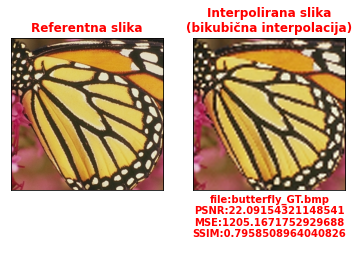

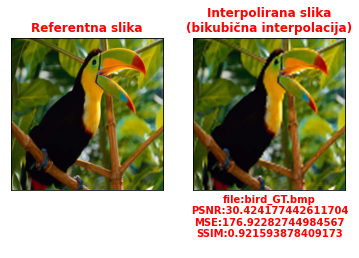

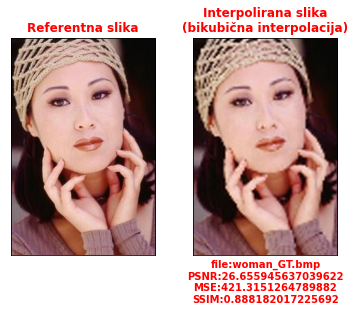

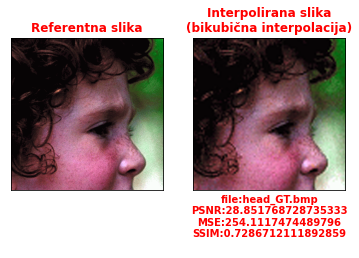

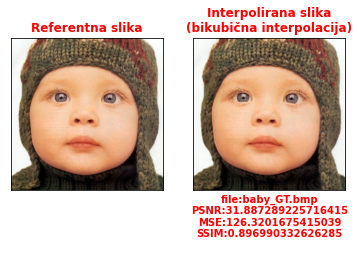

In [14]:
print(Fore.BLUE + 'Poredjenje originalne slike i interpolirane(bikubicna interpolacija)')
for file in os.listdir('drive/MyDrive/slike2/'):
  imageA = cv2.imread('drive/MyDrive/slike2/{}'.format(file))
  imageB = cv2.imread('drive/MyDrive/slike/Set5/{}'.format(file))
  
  Psnr = psnr1(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('Interpolirana slika\n(bikubična interpolacija)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('file:{}\nPSNR:{}\nMSE:{}\nSSIM:{}\n'.format(file,Psnr,Mse,SSIM),fontdict={'fontweight': 'bold','color':'red'})


Poredjenje originalne slike i interpolirane(bilinearna)


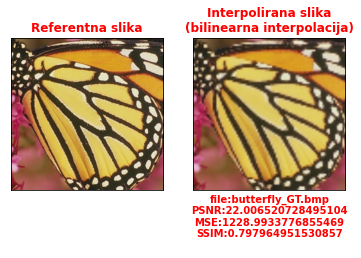

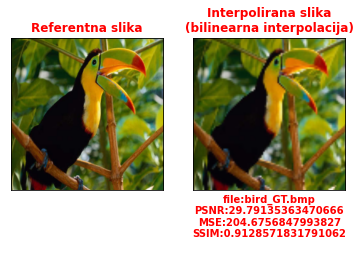

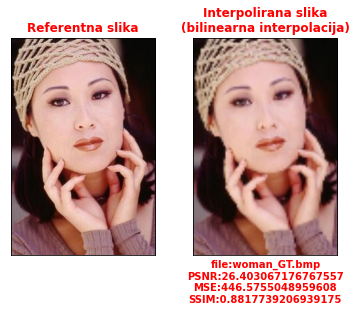

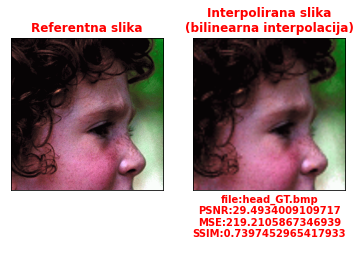

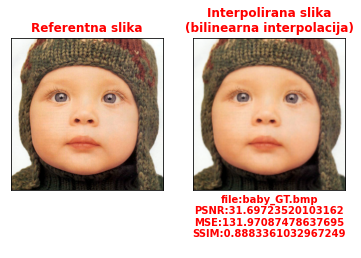

In [15]:
print(Fore.BLUE + 'Poredjenje originalne slike i interpolirane(bilinearna)')
for file in os.listdir('drive/MyDrive/slike1/'):
  imageA = cv2.imread('drive/MyDrive/slike1/{}'.format(file))
  imageB = cv2.imread('drive/MyDrive/slike/Set5/{}'.format(file))
  Psnr = psnr1(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  imgplot.set_clim(0.0, 0.7)
  ax.set_title('Interpolirana slika\n(bilinearna interpolacija)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('file:{}\nPSNR:{}\nMSE:{}\nSSIM:{}\n'.format(file,Psnr,Mse,SSIM),fontdict={'fontweight': 'bold','color':'red'})



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Poredjenje originalne slike i slike dobijene nakon primene SRCNN


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


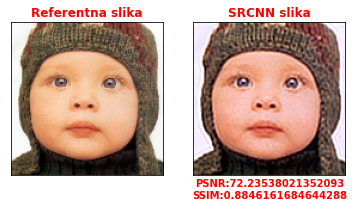

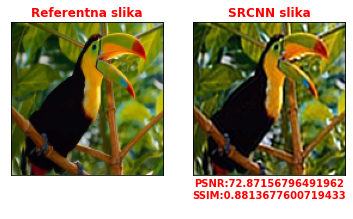

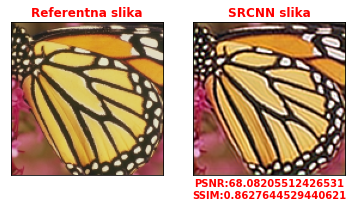

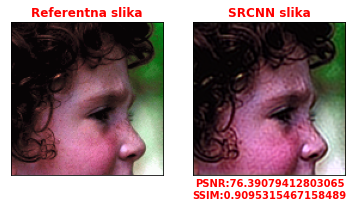

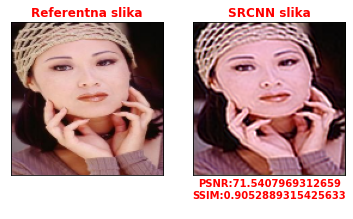

In [16]:
print(Fore.BLUE + 'Poredjenje originalne slike i slike dobijene nakon primene SRCNN')
i = 0
for i in range(5):
  imageA = result[i]
  imageB = testImage[i].astype(np.float32)
  
  i+=1
  Psnr = psnr1(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('SRCNN slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('PSNR:{}\nSSIM:{}\n'.format(Psnr,SSIM),fontdict={'fontweight': 'bold','color':'red'})
